## Relax_Inc Analysis 
by Ben Bellman for Springboard

## Instructions:

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

#### Data Wrangling

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss,matthews_corrcoef, ConfusionMatrixDisplay

from io import StringIO 
from IPython.display import Image,HTML 
import pydotplus
import graphviz
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## Load our data into dataframes
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [3]:
## Preview users
users.head()

object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  
0             10803.0  
1               316.0  
2              1525.0  
3              5151.0  
4              5240.0

In [4]:
## We rename object_id to be the user_id
users = users.rename(columns={'object_id':'user_id'})

In [5]:
## Preview Engagement
engagement.head()

time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1

In [6]:
## Let's check the info for engagement. 
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
## we convert the time_stamp to datetime.
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [8]:
## We look at our dataframe
df = engagement.set_index('time_stamp')
df.head()

user_id  visited
time_stamp                           
2014-04-22 03:53:30        1        1
2013-11-15 03:45:04        2        1
2013-11-29 03:45:04        2        1
2013-12-09 03:45:04        2        1
2013-12-25 03:45:04        2        1

In [9]:
## We find the pd.rolling method to help us achieve a rolling count of logins on a weekly interval: 
## https://stackoverflow.com/questions/62369235/using-pandas-to-count-user-orders-that-happen-within-the-hour-from-start-time-wi
weekly = df.groupby('user_id').visited.rolling('7D').count()
weekly.head()

user_id  time_stamp         
1        2014-04-22 03:53:30    1.0
2        2013-11-15 03:45:04    1.0
         2013-11-29 03:45:04    1.0
         2013-12-09 03:45:04    1.0
         2013-12-25 03:45:04    1.0
Name: visited, dtype: float64

In [10]:
## We want to get the max number of logins per user and create a new dataframe that contains our max logins in a week. 
logins = weekly.groupby('user_id').max()
logins.head()

user_id
1    1.0
2    3.0
3    1.0
4    1.0
5    1.0
Name: visited, dtype: float64

In [11]:
## Let's get the proportion that were active: 
active = logins[logins >2].count()
total = logins.count()
print('Activated Total: {}'.format(active))
print('Total Customers: {}'.format(total))
print('Proportion of activated customers: {}{}'.format(round(active/total,3)*100,'%'))

Activated Total: 1602
Total Customers: 8823
Proportion of activated customers: 18.2%


In [12]:
## We create a dataframe with the max one_week_visits in days.
logins = pd.DataFrame(logins).reset_index().rename(columns={'visited':'max_one_week_visits'})
logins.head()

user_id  max_one_week_visits
0        1                  1.0
1        2                  3.0
2        3                  1.0
3        4                  1.0
4        5                  1.0

In [13]:
# We merge our logins dataset with users. 
merged = pd.merge(users,logins, on ='user_id')
merged.head(3)

user_id        creation_time               name  \
0        1  2014-04-22 03:53:30     Clausen August   
1        2  2013-11-15 03:45:04      Poole Matthew   
2        3  2013-03-19 23:14:52  Bottrill Mitchell   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   

   invited_by_user_id  max_one_week_visits  
0             10803.0                  1.0  
1               316.0                  3.0  
2              1525.0                  1.0

In [14]:
## We convert the last_session time to a datetime format
merged['last_session_creation_time'] = pd.to_datetime(
    merged['last_session_creation_time'], unit='s')

merged.creation_time = pd.to_datetime(merged['creation_time'])
merged.head(3)

user_id       creation_time               name                       email  \
0        1 2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
1        2 2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
2        3 2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   

  creation_source last_session_creation_time  opted_in_to_mailing_list  \
0    GUEST_INVITE        2014-04-22 03:53:30                         1   
1      ORG_INVITE        2014-03-31 03:45:04                         0   
2      ORG_INVITE        2013-03-19 23:14:52                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  max_one_week_visits  
0                           0      11             10803.0                  1.0  
1                           0       1               316.0                  3.0  
2                           0      94              1525.0                  1.0

In [15]:
## We create an elapsed time column
merged['elapsed_time'] = (merged['last_session_creation_time'] - merged['creation_time']).dt.days

In [16]:
## Then we create our adopted column: 
merged['adopted']= np.where(merged.max_one_week_visits > 2,1,0)

In [17]:
## Now let's preview our df: 
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
 10  max_one_week_visits         8823 non-null   float64       
 11  elapsed_time                8823 non-null   int64       

The only columns missing values is invited_by_user_id, mostly missing values because they were not referred.

In [18]:
## We fill the blank recommend by user with 0 if someone has not been reccomended. 
merged.invited_by_user_id.fillna(0,inplace=True)

In [19]:
## We create a new column to see whether someone or not has been referred. 
merged['referred'] = np.where(merged.invited_by_user_id>0,1,0)
merged.head()

user_id       creation_time               name                       email  \
0        1 2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
1        2 2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
2        3 2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   
3        4 2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com   
4        5 2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com   

  creation_source last_session_creation_time  opted_in_to_mailing_list  \
0    GUEST_INVITE        2014-04-22 03:53:30                         1   
1      ORG_INVITE        2014-03-31 03:45:04                         0   
2      ORG_INVITE        2013-03-19 23:14:52                         0   
3    GUEST_INVITE        2013-05-22 08:09:28                         0   
4    GUEST_INVITE        2013-01-22 10:14:20                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  \
0                           0      11             10803.0   
1                           0       1               316.0   
2                           0      94              1525.0   
3                           0       1              5151.0   
4                           0     193              5240.0   

   max_one_week_visits  elapsed_time  adopted  referred  
0                  1.0             0        0         1  
1                  3.0           136        1         1  
2                  1.0             0        0         1  
3                  1.0             1        0         1  
4                  1.0             5        0         1

### EDA 

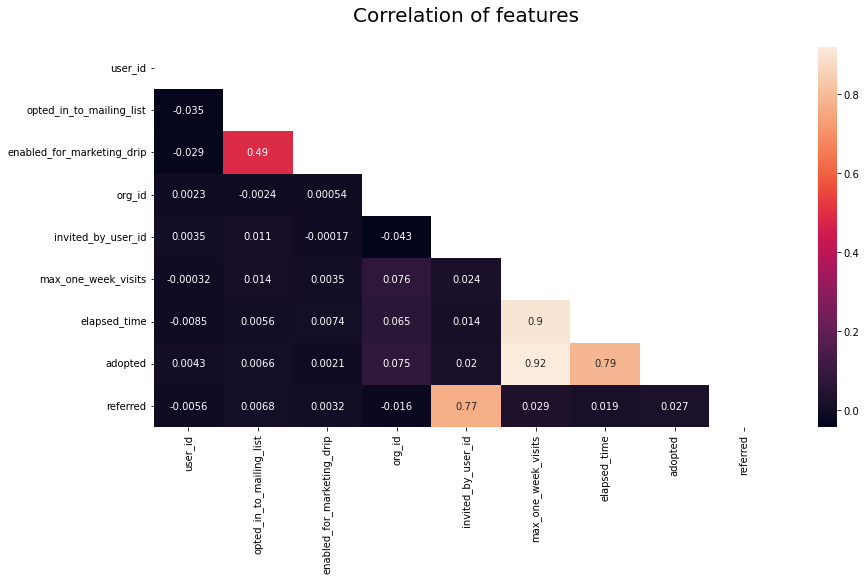

In [20]:
## Showing/; 
plt.figure(figsize = (14,7))

sns.heatmap(merged.corr(), annot = True, mask =np.triu(merged.corr()))
plt.title('Correlation of features', pad =25, size = 20)
plt.show()

### Modelling:

In [21]:
## We drop columns. 
cols_drop =['name','creation_time','email','last_session_creation_time','invited_by_user_id',
            'max_one_week_visits','user_id','org_id']
merged.drop(columns = cols_drop, inplace = True)

In [22]:
## We one hot encode our categorical features. 
dummies = pd.get_dummies(merged.creation_source, drop_first =True)

In [23]:
## We merge our encoced variables with our dataset...
final = pd.concat([merged,dummies], axis =1)

In [24]:
## ... and drop the original columns
final.drop(columns = 'creation_source', inplace = True)
final.head()

opted_in_to_mailing_list  enabled_for_marketing_drip  elapsed_time  \
0                         1                           0             0   
1                         0                           0           136   
2                         0                           0             0   
3                         0                           0             1   
4                         0                           0             5   

   adopted  referred  ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  \
0        0         1           0                  0       0   
1        1         1           1                  0       0   
2        0         1           1                  0       0   
3        0         1           0                  0       0   
4        0         1           0                  0       0   

   SIGNUP_GOOGLE_AUTH  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [25]:
X = final.drop(columns=['adopted'])
y = final.adopted

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)

<AxesSubplot:ylabel='adopted'>

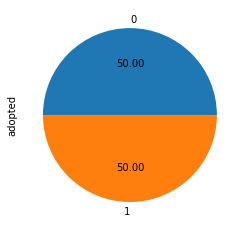

In [26]:
## Since we have class imbalance, we use the RandomUnderSampler 
rus = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
X_train, y_train = rus.fit_resample(X_train,y_train)
y_train.value_counts().plot.pie(autopct='%.2f')

In [27]:
'''
cols_to_scale = ['org_id',]
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()
'''

"\ncols_to_scale = ['org_id',]\nscaler = StandardScaler()\nscaler.fit(X[cols_to_scale])\n\nX_scaled = scaler.transform(X[cols_to_scale])\nfor ind, col in enumerate(cols_to_scale):\n    X[col] = X_scaled[:,ind]\nX.head()\n"

In [28]:
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ['gini','entropy'],
    'max_depth' : [2,4,5,6,7,8],
    'bootstrap':['False', 'True']
}

rfc_GS = RandomizedSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', random_state = 42)
rfc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 

print('Best Estimator:' +str(rfc_GS.best_estimator_))
print('Best Params:' +str(rfc_GS.best_params_))
print('Best Score:' +str(rfc_GS.best_score_))
#'''

Best Estimator:RandomForestClassifier(bootstrap='False', criterion='entropy', max_depth=5,
                       max_features='sqrt', n_estimators=200, random_state=42)
Best Params:{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': 'False'}
Best Score:0.9903383440374333


In [29]:
## We can see the feature importances in the model below...
rfc_best = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth= 2, 
                                  max_features= 'sqrt', n_estimators= 50, random_state = 42)


rfc_best.fit(X_train,y_train)
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

importance
elapsed_time                  0.795903
PERSONAL_PROJECTS             0.061066
referred                      0.055209
opted_in_to_mailing_list      0.044431
SIGNUP                        0.019269
enabled_for_marketing_drip    0.013414
ORG_INVITE                    0.010129
SIGNUP_GOOGLE_AUTH            0.000579

Random Forest Model Metrics:
ROC_AUC_SCORE: 0.989
Accuracy: 0.924
Precision: 0.722
Recall: 0.982
F1-Score: 0.832
Log Loss Score: 2.622
MCC: 0.8




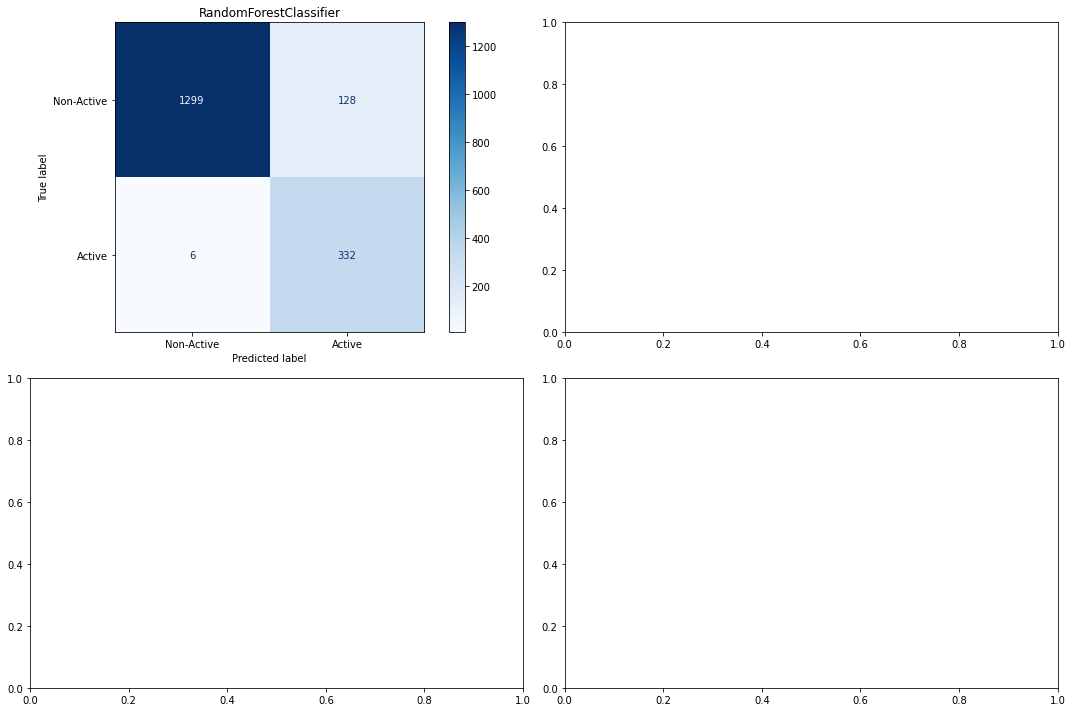

In [30]:
names = ["Random Forest"]
models = [rfc_best]

counter = 0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('{} Model Metrics:'.format(names[counter]))
    print('ROC_AUC_SCORE: ' + str(round(roc_auc,3)))
    print('Accuracy: ' + str(round(accuracy_score(y_test,y_pred),3)))
    print('Precision: '+ str(round(precision_score(y_test,y_pred),3)))
    print('Recall: ' + str(round(recall_score(y_test,y_pred),3)))
    print('F1-Score: ' + str(round(f1_score(y_test,y_pred),3)))
    print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
    print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
    print("\n")
    counter +=1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['Non-Active','Active'])
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()

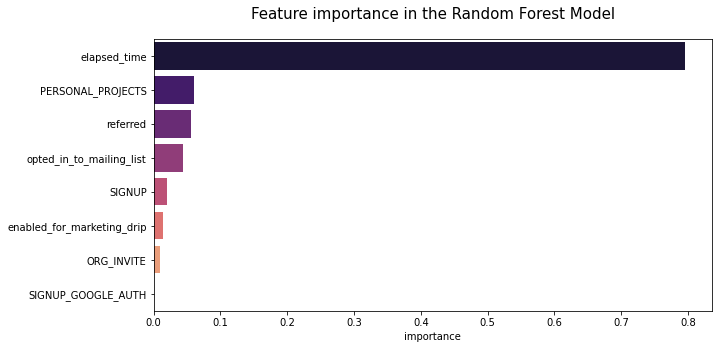

In [31]:
## ... and we can plot them. 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

## Conclusion:

- When using the elapsed time variable, the model is extremely accurate at 92.4% even when the data is trained unbiasly on a  50/50 split between active and non-active users. Therefore, the most likely factor to predict active customers will the time_elapsed variable which account for close to 80% of the feature importance in the model. 